# House Price Prediction Using PyTorch

This notebook builds a PyTorch neural network for house price prediction. An extra cell uses the correlation matrix to select the top five features most correlated with SalePrice.

In [5]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## 1. Load the Data

Replace the placeholder paths with the actual file paths.

In [6]:
# Replace these paths with the actual file paths
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


## 2. Data Preprocessing

Fill missing values, drop the `Id` column, separate the target `SalePrice`, and one-hot encode categorical features.

In [7]:
def fill_missing_values(df):
    # Fill numeric columns with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

# Process training data
train_df = fill_missing_values(train_df.copy())

# Save and drop the Id column
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Separate target variable and features
y = train_df['SalePrice']
X = train_df.drop('SalePrice', axis=1)

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

Processed training features shape: (1000, 230)


/tmp/ipykernel_10538/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_10538/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## 2.1 Feature Selection

Use the correlation matrix to select the top five features most correlated with SalePrice.

In [8]:
# Compute correlation matrix only on numeric columns (including SalePrice)
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Get top 5 features with highest absolute correlation with SalePrice (excluding SalePrice itself)
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:6].index.tolist()
print('Top 5 features selected:', top_features)

# Then, update X to keep only these features
X = X[top_features]
print('X shape after feature selection:', X.shape)

Top 5 features selected: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X shape after feature selection: (1000, 5)


### 2.2 Train-Validation Split and Scaling

Split the data and scale features.

In [9]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 5)
X_val_scaled shape: (200, 5)


## 3. Convert Data to PyTorch Tensors

Convert the numpy arrays to PyTorch tensors.

In [10]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

print('X_train_tensor shape:', X_train_tensor.shape)
print('X_val_tensor shape:', X_val_tensor.shape)

X_train_tensor shape: torch.Size([800, 5])
X_val_tensor shape: torch.Size([200, 5])


## 4. Define the PyTorch Neural Network Model

Build a feed-forward network with two hidden layers (128 and 64 nodes) and dropout.

In [11]:
class HousePriceNet(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = HousePriceNet(input_dim).to(device)
print(model)

HousePriceNet(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 5. Train the Model

Train using MSE loss and the Adam optimizer.

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [10/100], Train Loss: 41067618304.0000, Val Loss: 34067206144.0000
Epoch [20/100], Train Loss: 41067163648.0000, Val Loss: 34066790400.0000
Epoch [30/100], Train Loss: 41066450944.0000, Val Loss: 34066163712.0000
Epoch [40/100], Train Loss: 41065426944.0000, Val Loss: 34065238016.0000
Epoch [50/100], Train Loss: 41063907328.0000, Val Loss: 34063925248.0000
Epoch [60/100], Train Loss: 41061810176.0000, Val Loss: 34062084096.0000
Epoch [70/100], Train Loss: 41058746368.0000, Val Loss: 34059593728.0000
Epoch [80/100], Train Loss: 41054978048.0000, Val Loss: 34056282112.0000
Epoch [90/100], Train Loss: 41049882624.0000, Val Loss: 34051989504.0000
Epoch [100/100], Train Loss: 41043243008.0000, Val Loss: 34046521344.0000


## 6. Evaluate the Model

Compute RMSE on the validation set.

In [13]:
model.eval()
with torch.no_grad():
    val_preds = model(X_val_tensor).cpu().numpy().flatten()

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print('Validation RMSE:', rmse)

Validation RMSE: 184517.00027910707


## 7. Prepare Test Data and Make Predictions

Process test data in the same way, align features, scale, and predict.

In [14]:
# Fill missing values in test data
test_df = fill_missing_values(test_df.copy())

# Save the test Ids and drop the 'Id' column
test_ids = test_df['Id']
test_df.drop('Id', axis=1, inplace=True)

# Convert categorical features to dummy variables
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test dataframe to training features (fill missing columns with 0)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Scale test features
test_scaled = scaler.transform(test_df)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

# Predict on test data
model.eval()
with torch.no_grad():
    test_preds = model(test_tensor).cpu().numpy().flatten()

print('Test predictions shape:', test_preds.shape)

Test predictions shape: (460,)


/tmp/ipykernel_10538/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_10538/378753361.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## 8. Save the Predictions

Save predictions to a CSV file with columns **ID** and **SALEPRICE**.

In [15]:
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'SALEPRICE': test_preds
})

# Replace with your desired output path
predictions_csv_path = 'predictions_pytorch_v2.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print('Predictions saved to', predictions_csv_path)

Predictions saved to predictions_pytorch_v2.csv


## 9. (Optional) Plot Training and Validation Loss

Visualize the loss curves.

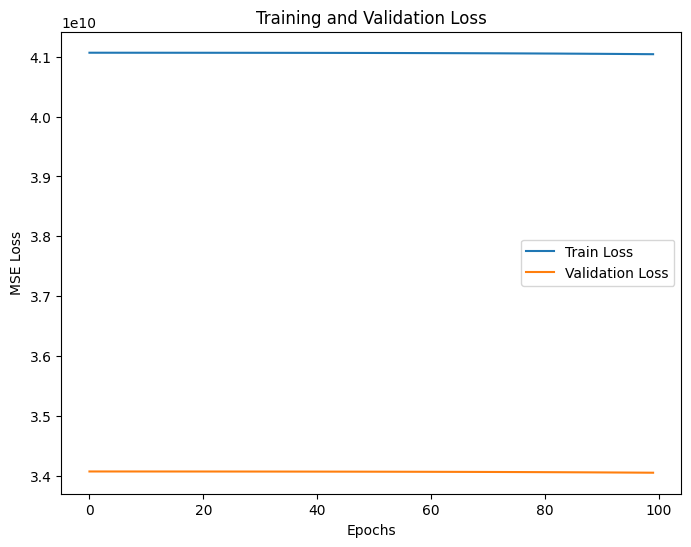

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()